In [31]:
%pip -q install xgboost
%pip -q install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 9.5 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 13.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 11.7 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle
import json
from time_series_split import *

In [2]:
def calculate_aqi(pm25):
    ranges = [
        (0.0, 12.0, 0, 50),
        (12.1, 35.4, 51, 100),
        (35.5, 55.4, 101, 150),
        (55.5, 150.4, 151, 200),
        (150.5, 250.4, 201, 300),
        (250.5, 500.0, 301, 500),
    ]
    for c_low, c_high, aqi_low, aqi_high in ranges:
        if c_low <= pm25 <= c_high:
            return round((aqi_high - aqi_low) / (c_high - c_low) * (pm25 - c_low) + aqi_low)
    return 500  # default nếu vượt ngưỡng

def aqi_class(aqi):
    if aqi <= 50: return 0
    elif aqi <= 100: return 1
    elif aqi <= 150: return 2
    elif aqi <= 200: return 3
    elif aqi <= 300: return 4
    else: return 5

In [3]:
combined_data = pd.read_csv('/home/thu/INT3041E_AI_PM2.5-Concentration-Estimation/data/consolidation/remotesensing_atmospheric.csv')
combined_data['AQI'] = combined_data['pm25'].apply(calculate_aqi)
combined_data['AQI_Class'] = combined_data['AQI'].apply(aqi_class)

In [4]:
combined_data.head()

,time,ID,pm25,lat,lon,SQRT_SEA_DEM_LAT,WSPD,WDIR,TMP,TX,...,NDVI,CO,HCHO,NO2,SO2,CLOUD,O3,AAI,AQI,AQI_Class
0,2020-01-01,19,116.949130,21.049750,105.741870,5.922647,1.136119,145.942749,20.811243,23.219995,...,0.000551,0.045586,0.000060,0.000072,0.000035,0.711612,0.101653,-0.836203,183,3
1,2020-01-01,79,105.103043,21.015250,105.800130,4.307231,1.136119,145.942749,20.811243,23.219995,...,-0.003006,0.041913,0.000107,0.000086,0.000056,0.761720,0.103635,-0.718537,177,3
2,2020-01-01,163,118.285100,21.024347,106.017288,4.988467,0.651509,145.395233,20.677492,23.029993,...,0.004388,0.042329,0.000108,0.000071,0.000026,0.867689,0.102144,-0.942304,183,3
3,2020-01-01,300,116.739130,21.023532,105.853941,4.865087,1.136119,145.942749,20.811243,23.219995,...,-0.001733,0.041913,0.000097,0.000085,0.000079,0.779294,0.102875,-0.692613,183,3
4,2020-01-02,19,76.856667,21.049750,105.741870,5.922647,2.744283,147.084442,22.176249,25.119989,...,0.016035,0.042298,0.000115,0.000082,-0.000345,0.705396,0.103488,-1.119681,162,3


In [5]:
# folds = split_original_data()
folds = split_consolidated_data()
print(f"Number of folds: {len(folds)}")

Number of folds: 3


In [34]:
fold = folds[0]
train_data = fold['train']
val_data = fold['validation']
test_data = fold['test']

In [35]:
# Chuẩn bị features và target từ các DataFrame
# Features: Loại trừ pm25, AQI, AQI_Class (tương tự cột 2 đến -2 trong combined_data)
feature_columns = train_data.columns[2:-2]  # Từ cột 2 (lat) đến cột -2 (AAI)

X_train = train_data[feature_columns]
y_train = train_data['AQI_Class']

X_val = val_data[feature_columns]
y_val = val_data['AQI_Class']

X_test = test_data[feature_columns]
y_test = test_data['AQI_Class']

In [36]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (10193, 20), y_train shape: (10193,)
X_val shape: (366, 20), y_val shape: (366,)
X_test shape: (327, 20), y_test shape: (327,)


## Tuning parameters

In [33]:
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=43)

**RandomForest**

In [ ]:
rf_params = {
    'n_estimators': [int(x) for x in np.linspace(100, 1200, 12)],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [int(x) for x in np.linspace(5, 30, 6)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_model = RandomForestClassifier(random_state=43, class_weight='balanced')
rf_search = RandomizedSearchCV(rf_model, rf_params, cv=strat_kfold, scoring='accuracy', n_iter=50, n_jobs=-1, random_state=43)
rf_search.fit(X_train, y_train)
rf_val_acc = rf_search.score(X_val, y_val)

**XGBoost**

In [ ]:
xgb_params = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
xgb_model = XGBClassifier(random_state=43, objective='multi:softmax', num_class=6, use_label_encoder=False, eval_metric='mlogloss')
xgb_search = RandomizedSearchCV(xgb_model, xgb_params, cv=strat_kfold, scoring='accuracy', n_iter=30, n_jobs=-1, random_state=43)
xgb_search.fit(X_train, y_train)
xgb_val_acc = xgb_search.score(X_val, y_val)


**CatBoost**

In [ ]:
cat_model = CatBoostClassifier(verbose=0, random_state=43)
cat_params = {
    'iterations': [100, 300, 500],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.3],
    'l2_leaf_reg': [1, 3, 5, 7]
}
cat_search = RandomizedSearchCV(cat_model, cat_params, cv=strat_kfold, scoring='accuracy', n_iter=30, n_jobs=-1, random_state=43)
cat_search.fit(X_train, y_train)
cat_val_acc = cat_search.score(X_val, y_val)


In [ ]:
models = {
    'RandomForest': (rf_search, rf_val_acc),
    'XGBoost': (xgb_search, xgb_val_acc),
    'CatBoost': (cat_search, cat_val_acc)
}

best_model_name = max(models, key=lambda k: models[k][1])
best_search, best_val_acc = models[best_model_name]
best_clf = best_search.best_estimator_
pred = best_clf.predict(X_test)

In [ ]:
print(f"Best Model: {best_model_name}")
print(f"Validation Accuracy: {best_val_acc:.4f}")

In [ ]:
# --- Trực quan hóa và đánh giá ---
sns.histplot(y_test - pred, kde=True)
plt.title(f'{best_model_name} - Prediction Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.show()

In [ ]:
all_labels = [0, 1, 2, 3, 4, 5]
target_names = ['Good', 'Moderate', 'Unhealthy for Sensitive', 'Unhealthy', 'Very Unhealthy', 'Hazardous']

cm = confusion_matrix(y_test, pred, labels=all_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(xticks_rotation=45)
plt.title(f'{best_model_name} - Confusion Matrix')
plt.show()

In [ ]:
print(f"Test Accuracy: {metrics.accuracy_score(y_test, pred):.4f}")
print("Classification Report (Test Set):")
print(metrics.classification_report(y_test, pred, labels=all_labels, target_names=target_names, zero_division=1))

In [ ]:
# Feature Importance (nếu hỗ trợ)
try:
    importances = best_clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices], y=X_train.columns[indices])
    plt.title(f'{best_model_name} - Feature Importances')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
except:
    print("This model does not support feature_importances_.")

In [ ]:
# Lưu model & metadata
pickle.dump(best_clf, open(f'{best_model_name.lower()}-classifier-tuning.pkl', 'wb'))

In [ ]:
metadata = {
    "model_name": best_model_name,
    "best_params": best_search.best_params_,
    "val_accuracy": best_val_acc,
    "test_accuracy": metrics.accuracy_score(y_test, pred),
    "features": list(feature_columns),
    "classes": sorted(list(set(y_train)))
}
with open(f"{best_model_name.lower()}_metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

**RandomForest**

In [ ]:
# # Tinh chỉnh siêu tham số trên tập validation
# n_estimators = [int(x) for x in np.linspace(start=100, stop=1200, num=12)]
# max_features = ['sqrt', 'log2']
# max_depth = [int(x) for x in np.linspace(5, 30, num=6)]
# min_samples_split = [2, 5, 10, 15, 20]
# min_samples_leaf = [1, 2, 5, 10]

# params = {
#     'n_estimators': n_estimators,
#     'max_features': max_features,
#     'max_depth': max_depth,
#     'min_samples_split': min_samples_split,
#     'min_samples_leaf': min_samples_leaf
# }

In [ ]:
# clf = RandomForestClassifier(random_state=43, class_weight='balanced')
# strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=43)

# search = RandomizedSearchCV(clf, params, scoring='accuracy', cv=strat_kfold, n_iter=100, n_jobs=-1, random_state=43)
# search.fit(X_train, y_train)
# val_accuracy = search.score(X_val, y_val)

In [ ]:
# print(f"Best parameters: {search.best_params_}")
# print(f"Best accuracy on validation set: {val_accuracy:.4f}")

Best parameters: {'n_estimators': 1200, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 15}
Best accuracy on validation set: 0.9945


In [ ]:
# results_df = pd.DataFrame(search.cv_results_)
# print(results_df[['mean_test_score', 'std_test_score', 'params']].sort_values(by='mean_test_score', ascending=False).head())

    mean_test_score  std_test_score  \
21         0.994408        0.000590   
83         0.994310        0.000797   
42         0.994310        0.000735   
10         0.994212        0.000481   
37         0.994212        0.000481   

                                               params  
21  {'n_estimators': 1200, 'min_samples_split': 15...  
83  {'n_estimators': 500, 'min_samples_split': 15,...  
42  {'n_estimators': 800, 'min_samples_split': 15,...  
10  {'n_estimators': 600, 'min_samples_split': 20,...  
37  {'n_estimators': 600, 'min_samples_split': 20,...  


In [ ]:
# # Dự đoán trên test set
# best_clf = search.best_estimator_
# pred = best_clf.predict(X_test)

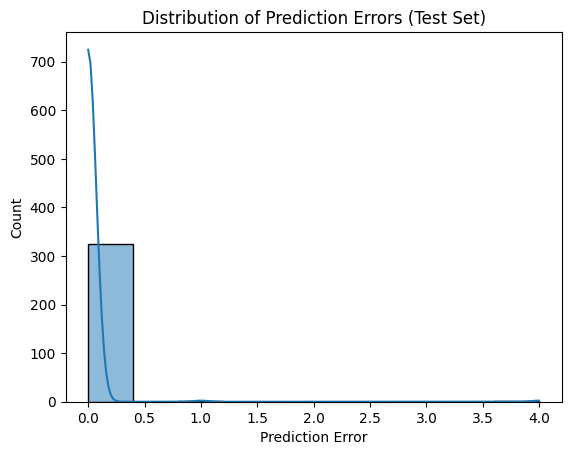

In [ ]:
# # Trực quan lỗi dự đoán
# sns.histplot(y_test - pred, kde=True)
# plt.title('Distribution of Prediction Errors (Test Set)')
# plt.xlabel('Prediction Error')
# plt.ylabel('Count')
# plt.show()

In [ ]:
# print("Unique labels in y_test:", set(y_test))
# print("Unique labels in pred:", set(pred))

Unique labels in y_test: {0, 1, 2, 3, 5}
Unique labels in pred: {np.int64(0), np.int64(1), np.int64(2), np.int64(3)}


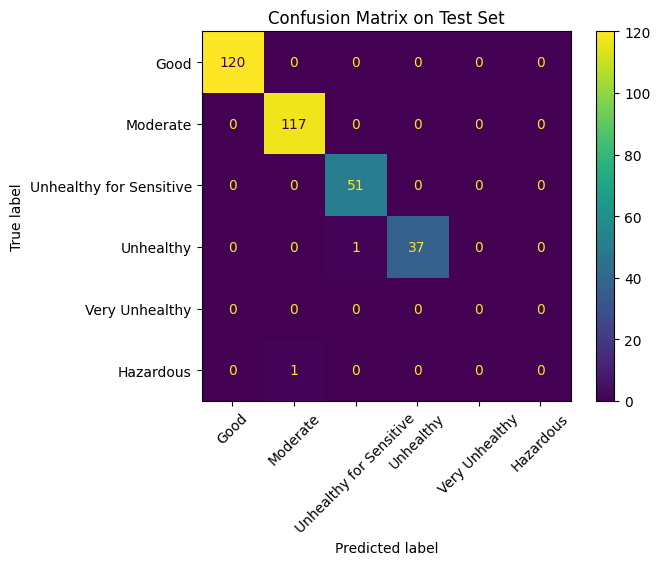

In [21]:
# # Confusion Matrix
# cm = confusion_matrix(y_test, pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[
#     'Good', 'Moderate', 'Unhealthy for Sensitive', 'Unhealthy', 'Very Unhealthy', 'Hazardous'])
# disp.plot(xticks_rotation=45)
# plt.title('Confusion Matrix on Test Set')
# plt.show()

all_labels = [0, 1, 2, 3, 4, 5]
cm = confusion_matrix(y_test, pred, labels=all_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[
    'Good', 'Moderate', 'Unhealthy for Sensitive', 'Unhealthy', 'Very Unhealthy', 'Hazardous'])
disp.plot(xticks_rotation=45)
plt.title('Confusion Matrix on Test Set')
plt.show()

In [16]:
# Feature importance
importances = best_clf.feature_importances_
indices = np.argsort(importances)[::-1]

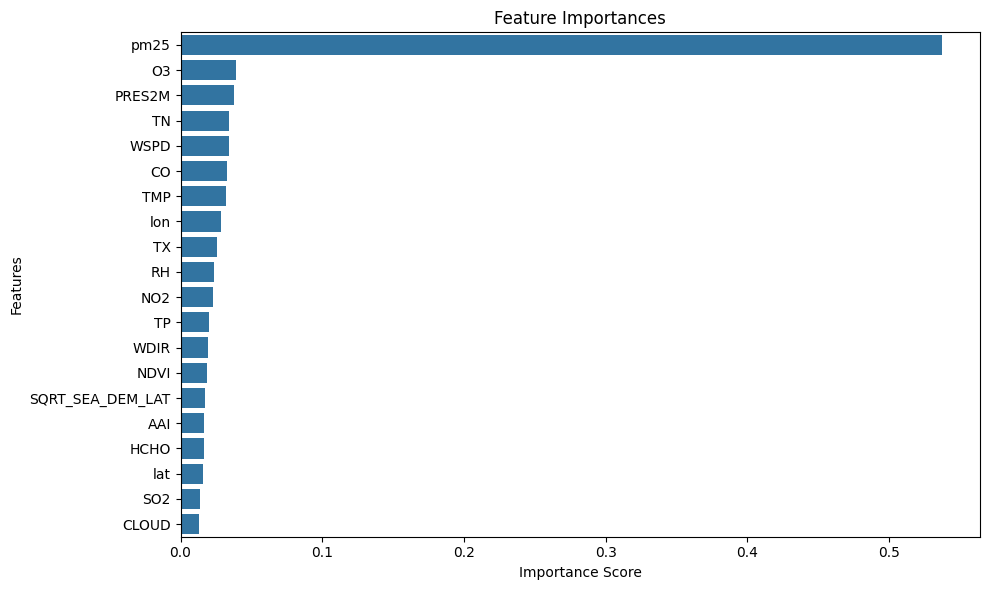

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=X_train.columns[indices])
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [27]:
all_labels = [0, 1, 2, 3, 4, 5]
target_names = ['Good', 'Moderate', 'Unhealthy for Sensitive', 'Unhealthy', 'Very Unhealthy', 'Hazardous']

# Đánh giá chi tiết
print(f"Accuracy on test set: {metrics.accuracy_score(y_test, pred):.4f}")
print("Classification Report (Test Set):")
print(metrics.classification_report(y_test, pred, labels=all_labels, target_names=target_names, zero_division=1))

print("Unique labels in y_test:", set(y_test))
print("Unique labels in pred:", set(pred))

Accuracy on test set: 0.9939
Classification Report (Test Set):
                         precision    recall  f1-score   support

                   Good       1.00      1.00      1.00       120
               Moderate       0.99      1.00      1.00       117
Unhealthy for Sensitive       0.98      1.00      0.99        51
              Unhealthy       1.00      0.97      0.99        38
         Very Unhealthy       1.00      1.00      1.00         0
              Hazardous       1.00      0.00      0.00         1

               accuracy                           0.99       327
              macro avg       1.00      0.83      0.83       327
           weighted avg       0.99      0.99      0.99       327

Unique labels in y_test: {0, 1, 2, 3, 5}
Unique labels in pred: {np.int64(0), np.int64(1), np.int64(2), np.int64(3)}


In [28]:
pickle.dump(best_clf, open('randomforest-classifier-tuning.pkl', 'wb'))

In [29]:
# Lưu metadata
metadata = {
    "best_params": search.best_params_,
    "val_accuracy": val_accuracy,
    "test_accuracy": metrics.accuracy_score(y_test, pred),
    "features": list(feature_columns),
    "classes": sorted(list(set(y_train)))
}
with open("rf_metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)